# WEB SCRAPPING

In [10]:
pip install beautifulsoup4

In [11]:
pip install requests

In [145]:
# Importação das bibliotecas
import pandas as pd
from bs4 import BeautifulSoup
import requests
from datetime import datetime
import sqlite3
from datetime import datetime

In [146]:
# URL do site de eventos de onde os dados serão extraídos
response = requests.get('https://www.sympla.com.br/eventos/rio-de-janeiro-rj')

content = response.content

site = BeautifulSoup(content, 'html.parser')

In [147]:
# Tags de onde os dados serão obtidos
nome_eventos = site.findAll(['h3'])
localizacoes = site.findAll('div', attrs={'class': 'EventCardstyle__EventLocation-sc-1rkzctc-8 heVhPT animated fadeIn'})
datas = site.findAll('div', attrs={'class': 'sc-1sp59be-0 dwFxpq'})

# Lista que gauardará inicialmente os valores
eventos = []

# Extraindo os valores
for title, localizacao, data in zip(nome_eventos, localizacoes, datas):

  evento = {'titulo': '',
         'localizacao': '',
         'data': ''
         }

  evento['titulo'] = title.text
  evento['localizacao'] = localizacao.text
  evento['data'] = data.text

  # Adicionando os valores no dicionário
  eventos.append(evento)

In [148]:
evento

{'titulo': 'EVANDRO MESQUITA & THE FABULOUS TAB',
 'localizacao': 'Cidade das Artes - Rio de Janeiro, RJ',
 'data': 'Qui, 20 Jun · 20:30'}

# PADRONIZAÇÃO DAS INFORMAÇÕES DE ***EVENTOS***

In [149]:
# Dataframe com os dados extraídos
df = pd.DataFrame(eventos)

df['id'] = range(1, len(df) + 1)
df['tipo'] = 'show'

# Cria o dataframe df_eventos com as colunas necessárias
df_eventos = df[['id', 'titulo', 'tipo']].copy()

# Adiciona a coluna id_evento
df_eventos['id_evento'] = df_eventos['id'].apply(lambda x: f"{x:03}")

# Apenas as colunas necessárias
df_eventos = df_eventos[['id_evento', 'titulo', 'tipo']]

In [150]:
df_eventos

,id_evento,titulo,tipo
0,001,ALUNOS QUERIDOS - AULAS AO VIVO I Terça 11/06,show
1,002,EMBAIXADORES - AULAS AO VIVO I Terça 11/06,show
2,003,ALMOÇO E JANTAR COM MÚSICA AMBIENTE NO ALTO ...,show
3,004,"Pink Flamingo | Super Mondays | - Segunda, 10...",show
4,005,Galaxion Rio,show
5,006,CONFRARIA NACIONAL EU MULHER,show
6,007,Simulação: Crise Humanitária de Cabo Delgado,show
7,008,TIM BERNARDES,show
8,009,Isso Não É Uma Festa,show
9,010,Alma Festival 24' @ Riocentro /RJ,show


# PADRONIZAÇÃO DAS INFORMAÇÕES DE ***DADOS EVENTOS***

In [173]:
df = pd.DataFrame(eventos)
df['id'] = range(1, len(df) + 1)
df['data'] = df['data'].str.replace(r'([A-Za-z]+)(\d{2})', r'\1 > \2', regex=True)

# Identificando as linhas que têm duas datas (evento que acontece mais de 1 dia)
df_split = df[df['data'].str.contains('>')].copy()

novas_linhas = []

# Iterar as linhas com duas datas
for index, row in df_split.iterrows():
    datas = row['data'].split('>')
    # Criar uma nova linha para cada data
    for data in datas:
        nova_linha = row.copy()
        nova_linha['data'] = data.strip()
        novas_linhas.append(nova_linha)

# Concatenar as novas linhas
df = pd.concat([df.drop(df_split.index), pd.DataFrame(novas_linhas)], ignore_index=True)

# Função para converter mês em texto para número
def mes_para_numero(mes):
    meses = {
        'Jan': '01',
        'Fev': '02',
        'Mar': '03',
        'Abr': '04',
        'Mai': '05',
        'Jun': '06',
        'Jul': '07',
        'Ago': '08',
        'Set': '09',
        'Out': '10',
        'Nov': '11',
        'Dez': '12'
    }
    return meses[mes]

df['data_corrigida'] = df['data'].str.extract(r'(\d{2} \w{3})')

# Adicionando o ano e convertendo para o formato yyyy-mm-dd
ano_corrente = datetime.now().year
df['data_padronizada'] = df['data_corrigida'].apply(lambda x: f"{ano_corrente}-{mes_para_numero(x.split()[1])}-{x.split()[0]}")
df['uf'] = df['localizacao'].str.extract(r'(\b[A-Z]{2}\b)$')

In [152]:
# Remover os valores de UF da coluna 'localizacao'
df['localizacao'] = df.apply(lambda row: row['localizacao'].replace(f", {row['uf']}", '').strip() if pd.notnull(row['uf']) else row['localizacao'], axis=1)

In [153]:
# Ajustando os dados dos eventos
df_eventos = df[['id', 'titulo']].copy()
df_eventos['tipo'] = 'show'
df_eventos['id_evento'] = df_eventos['id'].apply(lambda x: f"{x:03}")
df_eventos = df_eventos[['id_evento', 'titulo', 'tipo']]
df_eventos['titulo'] = df_eventos['titulo'].str.strip().str.lower()

In [154]:
# Criando o dataframe final com os dados do evento
df_dados_evento = df[['id', 'titulo', 'localizacao', 'data_padronizada', 'uf']].copy()
df_dados_evento['titulo'] = df_dados_evento['titulo'].str.strip().str.lower()

# Realizar a junção dos dataframes
df_dados_evento = df_dados_evento.merge(df_eventos[['titulo', 'id_evento']], on='titulo', how='left')

In [155]:
# Função para determinar o tipo de instalação
def determinar_tipo_instalacao(localizacao):
    if any(x in localizacao.lower() for x in ['shopping', 'hotel', 'fundição', 'clube', 'bar', 'quadra', 'teatro']):
        return 'fechada'
    else:
        return 'ar livre'

In [156]:
# Criar a coluna 'tipo_instalacao' com base na coluna 'localizacao'
df_dados_evento['tipo_instalacao'] = df_dados_evento['localizacao'].apply(determinar_tipo_instalacao)

In [157]:
# Renomear a coluna 'id' para 'id_dados_evento'
df_dados_evento.rename(columns={'id': 'id_dados_evento'}, inplace=True)

# Selecionar apenas as colunas desejadas
df_dados_evento = df_dados_evento[['id_dados_evento', 'id_evento', 'localizacao', 'data_padronizada', 'uf', 'tipo_instalacao']]

In [158]:
df_dados_evento

,id_dados_evento,id_evento,localizacao,data_padronizada,uf,tipo_instalacao
0,4,004,Pink Flamingo - Rio de Janeiro,2024-06-10,RJ,ar livre
1,8,008,Vivo Rio - Rio de Janeiro,2024-08-24,RJ,ar livre
2,9,009,Rio de Janeiro - Rio de Janeiro,2024-07-27,RJ,ar livre
3,10,010,Riocentro - Rio de Janeiro,2024-07-13,RJ,ar livre
4,11,011,Vivo Rio - Rio de Janeiro,2024-08-30,RJ,ar livre
5,12,012,Cidade das Artes - Rio de Janeiro,2024-06-25,RJ,ar livre
6,13,013,AGYTO RIO - Rio de Janeiro,2024-07-06,RJ,ar livre
7,14,014,Bangu Shopping - Rio de Janeiro,2024-06-16,RJ,fechada
8,15,015,Teatro Firjan SESI CENTRO . - Rio de Janeiro,2024-06-19,RJ,fechada
9,16,016,Escola Nova by SIS - Rio de Janeiro,2024-06-28,RJ,ar livre


# PADRONIZAÇÃO DAS INFORMAÇÕES DE ***METADADOS***

In [159]:
df = df_eventos

df['id_metadado'] = range(1, len(df) + 1)

# Requisição HTTP e obter o conteúdo HTML
url = "https://www.sympla.com.br/eventos/rio-de-janeiro-rj/hoje"
html = requests.get(url).content
soup = BeautifulSoup(html, 'html.parser')
formatted_html = soup.prettify()

df['metadado'] = formatted_html

df_metadados = df[['id_metadado','id_evento','metadado']]

In [160]:
df_metadados

,id_metadado,id_evento,metadado
0,1,004,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
1,2,008,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
2,3,009,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
3,4,010,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
4,5,011,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
5,6,012,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
6,7,013,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
7,8,014,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
8,9,015,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."
9,10,016,"<!DOCTYPE html>\n<html data-reactroot="""" dir=""..."


# CRIAÇÃO DAS TABELAS

In [163]:
# Criar conexão com o banco de dados
conn = sqlite3.connect('dados_eventos.db')
cursor = conn.cursor()

# Truncate na tabela para conseguir recriar o código
#cursor.execute('''DELETE FROM EVENTOS''')

# Criar tabela EVENTOS
cursor.execute('''CREATE TABLE IF NOT EXISTS EVENTOS (
                    id_evento   INTEGER PRIMARY KEY,
                    titulo      VARCHAR(300),
                    tipo        VARCHAR(100)
                )''')
# Remover duplicatas no DataFrame
df_eventos.drop_duplicates(subset='id_evento', keep='first', inplace=True)

# Inserir dados do df_eventos na tabela EVENTOS
for index, row in df_eventos.iterrows():
    cursor.execute('''INSERT INTO EVENTOS (id_evento, titulo, tipo)
                      VALUES (?, ?, ?)''', (row['id_evento'], row['titulo'], row['tipo']))


# Commit das alterações e fechamento da conexão
conn.commit()
conn.close()
print("Tabela 'EVENTOS' criada e dados inseridos com sucesso.")

Tabela 'EVENTOS' criada e dados inseridos com sucesso.


In [164]:
conn = sqlite3.connect('dados_eventos.db')
cursor = conn.cursor()

# Truncate na tabela para conseguir recriar o código
#cursor.execute('''DELETE FROM DADOS_EVENTO''')

# Criar tabela DADOS_EVENTO
cursor.execute('''CREATE TABLE IF NOT EXISTS DADOS_EVENTO (
                    id_dados_evento INTEGER PRIMARY KEY,
                    id_evento       VARCHAR(100),
                    localizacao     VARCHAR(300),
                    data_padronizada   DATE,
                    uf              VARCHAR(10),
                    tipo_instalacao VARCHAR(100)
                )''')

# Remover duplicatas no DataFrame
df_dados_evento.drop_duplicates(subset='id_dados_evento', keep='first', inplace=True)

# Inserir dados do df_dados_evento na tabela DADOS_EVENTO
for index, row in df_dados_evento.iterrows():
    cursor.execute('''INSERT INTO DADOS_EVENTO (id_dados_evento, id_evento, localizacao, data_padronizada, uf, tipo_instalacao)
                      VALUES (?, ?, ?, ?, ?, ?)''', (row['id_dados_evento'], row['id_evento'], row['localizacao'], row['data_padronizada'], row['uf'], row['tipo_instalacao']))

# Commit das alterações e fechamento da conexão
conn.commit()
conn.close()
print("Tabela 'DADOS_EVENTO' criada e dados inseridos com sucesso.")

Tabela 'DADOS_EVENTO' criada e dados inseridos com sucesso.


In [165]:
conn = sqlite3.connect('dados_eventos.db')
cursor = conn.cursor()

# Truncate na tabela para conseguir recriar o código
#cursor.execute('''DELETE FROM METADADOS''')

# Criar tabela METADADOS
cursor.execute('''CREATE TABLE IF NOT EXISTS METADADOS (
                    id_metadado   INTEGER PRIMARY KEY,
                    id_evento     VARCHAR(100),
                    metadado      TEXT
                )''')

# Inserir dados do df_metadados na tabela METADADOS
for index, row in df_metadados.iterrows():
    cursor.execute('''INSERT INTO METADADOS (id_metadado, id_evento, metadado)
                      VALUES (?, ?, ?)''', (row['id_metadado'], row['id_evento'], row['metadado']))

# Commit das alterações e fechamento da conexão
conn.commit()
conn.close()
print("Tabela 'METADADOS' criada e dados inseridos com sucesso.")

Tabela 'METADADOS' criada e dados inseridos com sucesso.


# CONSULTAS

1- Mostrar todos os eventos com suas datas, localização e tipos de evento

In [168]:
conn = sqlite3.connect('dados_eventos.db')
cursor = conn.cursor()

# QUERY
sql_query = '''
            SELECT e.titulo, de.localizacao, de.data_padronizada, de.uf, e.tipo
            FROM EVENTOS e
            JOIN DADOS_EVENTO de
              ON e.id_evento = de.id_evento
            '''

# Executar a consulta SQL
cursor.execute(sql_query)
resultados = cursor.fetchall()

# Mostrar os resultados
for resultado in resultados:
    titulo, localizacao, data, uf, tipo_evento = resultado
    print(f"Evento: {titulo}\nLocalização: {localizacao}\nData: {data}\nUF: {uf}\nTipo de Evento: {tipo_evento}\n")

# Fechar a conexão com o banco de dados
conn.close()

Evento: alunos queridos - aulas ao vivo i terça 11/06
Localização: Barra Business Center - Rio de Janeiro
Data: 2024-06-10
UF: RJ
Tipo de Evento: show

Evento: embaixadores - aulas ao vivo i terça 11/06
Localização: Barra Business Center - Rio de Janeiro
Data: 2024-06-10
UF: RJ
Tipo de Evento: show

Evento: almoço e jantar  com música ambiente no  alto vidigal brasil
Localização: Alto Vidigal Brasil - Rio de Janeiro
Data: 2024-06-10
UF: RJ
Tipo de Evento: show

Evento: pink flamingo | super mondays |  - segunda, 10 de junho - 21h
Localização: Pink Flamingo - Rio de Janeiro
Data: 2024-06-10
UF: RJ
Tipo de Evento: show

Evento: galaxion rio
Localização: Fashion Mall - Rio de Janeiro
Data: 2024-06-10
UF: RJ
Tipo de Evento: show

Evento: confraria nacional eu mulher
Localização: R. Francisco Sá, 90 - Rio de Janeiro
Data: 2024-06-10
UF: RJ
Tipo de Evento: show

Evento: simulação: crise humanitária de cabo delgado
Localização: Centro de Ciências Jurídicas e Políticas - Rio de Janeiro
Data: 2

2- Mostrar os dados dos 2 eventos mais próximos de iniciar

In [169]:
conn = sqlite3.connect('dados_eventos.db')
cursor = conn.cursor()

# Obter a data atual
current_date = datetime.now().strftime('%Y-%m-%d')

# Query
sql_query = f'''
            SELECT e.titulo, de.localizacao, de.data_padronizada, de.uf, e.tipo
            FROM EVENTOS e
            JOIN DADOS_EVENTO de ON e.id_evento = de.id_evento
            WHERE de.data_padronizada >= date('{current_date}')
            ORDER BY de.data_padronizada
            LIMIT 2
            '''

cursor.execute(sql_query)
resultados = cursor.fetchall()

for resultado in resultados:
    titulo, localizacao, data, uf, tipo_evento = resultado
    print(f"\nEvento: {titulo}\n\nLocalização: {localizacao}\nData: {data}\nUF: {uf}\nTipo de Evento: {tipo_evento}\n")

conn.close()


Evento: city and colour

Localização: Vivo Rio - Rio de Janeiro
Data: 2024-06-14
UF: RJ
Tipo de Evento: show


Evento: anavitória & nando reis - turnê dos namorados 'palavras iguais dizendo coisas tão diferentes'

Localização: Vivo Rio - Rio de Janeiro
Data: 2024-06-15
UF: RJ
Tipo de Evento: show



3- Mostrar os eventos que acontecem no Rio de Janeiro

In [170]:
conn = sqlite3.connect('dados_eventos.db')
cursor = conn.cursor()

# Query
sql_query = '''
            SELECT e.titulo, de.uf, de.data_padronizada, de.localizacao
            FROM EVENTOS e
            JOIN DADOS_EVENTO de ON e.id_evento = de.id_evento
            WHERE de.uf = 'RJ'
            '''

cursor.execute(sql_query)
resultados = cursor.fetchall()

for resultado in resultados:
    titulo, uf, data, localizacao = resultado
    print(f"Evento: {titulo}\nUF: {uf}\nData: {data}\nLocalização: {localizacao}\n\n")

conn.close()

Evento: alunos queridos - aulas ao vivo i terça 11/06
UF: RJ
Data: 2024-06-10
Localização: Barra Business Center - Rio de Janeiro


Evento: embaixadores - aulas ao vivo i terça 11/06
UF: RJ
Data: 2024-06-10
Localização: Barra Business Center - Rio de Janeiro


Evento: almoço e jantar  com música ambiente no  alto vidigal brasil
UF: RJ
Data: 2024-06-10
Localização: Alto Vidigal Brasil - Rio de Janeiro


Evento: pink flamingo | super mondays |  - segunda, 10 de junho - 21h
UF: RJ
Data: 2024-06-10
Localização: Pink Flamingo - Rio de Janeiro


Evento: galaxion rio
UF: RJ
Data: 2024-06-10
Localização: Fashion Mall - Rio de Janeiro


Evento: confraria nacional eu mulher
UF: RJ
Data: 2024-06-10
Localização: R. Francisco Sá, 90 - Rio de Janeiro


Evento: simulação: crise humanitária de cabo delgado
UF: RJ
Data: 2024-06-10
Localização: Centro de Ciências Jurídicas e Políticas - Rio de Janeiro


Evento: tim bernardes
UF: RJ
Data: 2024-08-24
Localização: Vivo Rio - Rio de Janeiro


Evento: isso n

4- Mostrar todos os eventos que são ao ar livre

In [171]:
conn = sqlite3.connect('dados_eventos.db')
cursor = conn.cursor()

# Query
sql_query = '''
            SELECT e.titulo, de.tipo_instalacao, de.data_padronizada, de.uf, de.localizacao
            FROM EVENTOS e
            JOIN DADOS_EVENTO de ON e.id_evento = de.id_evento
            WHERE de.tipo_instalacao = 'ar livre'
            '''

cursor.execute(sql_query)
resultados = cursor.fetchall()

for resultado in resultados:
    titulo, tipo_instalacao, data, uf, localizacao = resultado
    print(f"Evento: {titulo}\nTipo de Instalação: {tipo_instalacao}\nData: {data}\nUF: {uf}\nLocalização: {localizacao}\n\n")

conn.close()

Evento: almoço e jantar  com música ambiente no  alto vidigal brasil
Tipo de Instalação: ar livre
Data: 2024-06-10
UF: RJ
Localização: Alto Vidigal Brasil - Rio de Janeiro


Evento: pink flamingo | super mondays |  - segunda, 10 de junho - 21h
Tipo de Instalação: ar livre
Data: 2024-06-10
UF: RJ
Localização: Pink Flamingo - Rio de Janeiro


Evento: galaxion rio
Tipo de Instalação: ar livre
Data: 2024-06-10
UF: RJ
Localização: Fashion Mall - Rio de Janeiro


Evento: confraria nacional eu mulher
Tipo de Instalação: ar livre
Data: 2024-06-10
UF: RJ
Localização: R. Francisco Sá, 90 - Rio de Janeiro


Evento: simulação: crise humanitária de cabo delgado
Tipo de Instalação: ar livre
Data: 2024-06-10
UF: RJ
Localização: Centro de Ciências Jurídicas e Políticas - Rio de Janeiro


Evento: tim bernardes
Tipo de Instalação: ar livre
Data: 2024-08-24
UF: RJ
Localização: Vivo Rio - Rio de Janeiro


Evento: isso não é uma festa
Tipo de Instalação: ar livre
Data: 2024-07-27
UF: RJ
Localização: Rio de

5- Mostrar todos os Metadados por evento

Evento: pink flamingo | super mondays |  - segunda, 10 de junho - 21h
Id_Evento: 004
Metadado: <!DOCTYPE html>
<html data-reactroot="" dir="ltr" lang="pt-BR">
 <head>
  <title>
   Eventos no Rio hoje em Rio de Janeiro - Sympla
  </title>
  <meta content="Encontre eventos no rio hoje e muito mais na Sympla. São diversas opções de eventos gratuitos e pagos em Rio de Janeiro. Descubra!" name="description"/>
  <head>
   <meta content="summary" name="twitter:card"/>
   <meta content="@Sympla" name="twitter:site"/>
   <meta content="301303029947066" property="fb:app_id"/>
   <meta content="https://www.sympla.com.br/eventos/rio-de-janeiro-rj/hoje" property="og:url"/>
   <meta content="website" property="og:type"/>
   <meta content="Eventos no Rio hoje em Rio de Janeiro - Sympla" property="og:title"/>
   <meta content="Encontre eventos no rio hoje e muito mais na Sympla. São diversas opções de eventos gratuitos e pagos em Rio de Janeiro. Descubra!" property="og:description"/>
   <meta content=
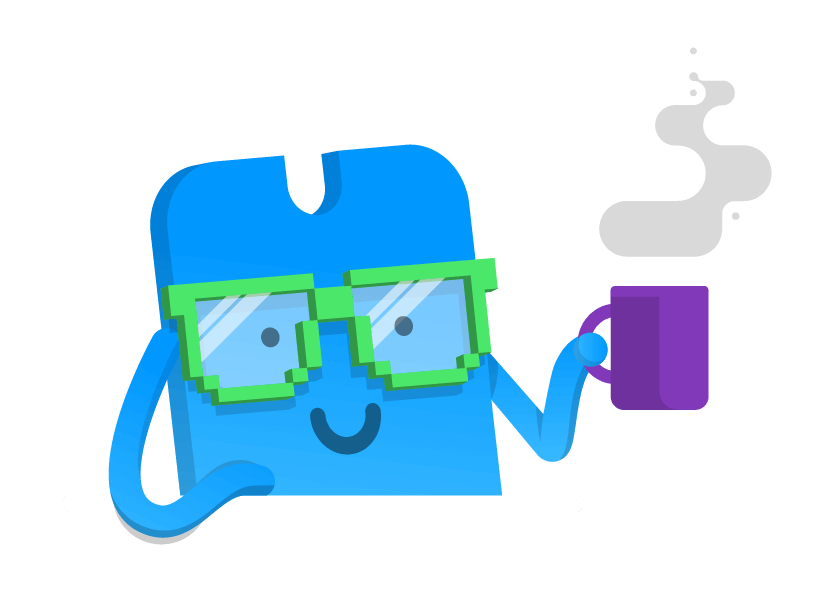

In [172]:
conn = sqlite3.connect('dados_eventos.db')
cursor = conn.cursor()

# Query
sql_query = '''
            SELECT e.titulo, md.id_evento, md.metadado
            FROM EVENTOS e
            JOIN METADADOS md ON e.id_evento = md.id_evento
            LIMIT 1 -- como o metadado ficou mt extenso, acabei colocando o limit, só para ver um valor
            '''

cursor.execute(sql_query)
resultados = cursor.fetchall()

for resultado in resultados:
    titulo, id_evento, metadado = resultado
    print(f"Evento: {titulo}\nId_Evento: {id_evento}\nMetadado: {metadado}\n\n")

conn.close()